# Development of sentiment analysis for the customer's task

A customer came to your company and needs a solution of the problem of analyzing the sentiment of product reviews. The customer wants you to evaluate the possible performance of such an algorithm on a small test sample (without labels). No more data is provided to you.

You have to look at the reviews provided by the customer, collect similar reviews as a training sample, and experiment with setting the problem (label positive and negative examples) so that the result on the customer's reviews is as good as possible (strictly more than 85%).

Please note that the customer provided only 100 examples as a test sample. A situation when there is almost no labeled data, in general, is very common in industrial data analysis.

This problem is stated as a Kaggle-competition https://www.kaggle.com/c/morecomplicatedsentiment.

On this page you can find two files:

- test.csv - the test sample in the format:

$<review>$ review_text_1 $</review>$ two line feeds $<review>$ review_text_2 $</review>$, etc.

- sample_submission.csv - the example of submission file, here you can see the required file format.

All reviews and the original problem are stated in russian.

## 1. Data extraction and preparation

In [179]:
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
import codecs
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import pickle
import joblib
import warnings
warnings.filterwarnings("ignore")

Upload scraped reviews and their scores form Yandex market. Removing duplicates we get 21310 unique reviews.

In [180]:
train = pd.read_json('train.json', orient='records', lines=True).drop_duplicates()

In [181]:
train

,review,score
0,Достоинства:\n• Батарея 6000 мАч\n• Стерео дин...,4
1,Достоинства: Долгое время автономной работы; с...,5
2,"Достоинства: Большой экран, громкий, и долго д...",5
3,Достоинства: Энергоемкость батареи и производи...,5
4,"Достоинства: Долго держит заряд, большая вмест...",5
...,...,...
24181,Достоинства: Интернет не томозит\nНедостатки: ...,4
24182,Недостатки: я его потерял,4
24183,Достоинства: Хороший не дорогой,5
24184,"Достоинства: Цена, память",5


In [182]:
train.isnull().sum()

review    0
score     0
dtype: int64

Now we need to clean the reviews.

Each review consists of 3 parts: "Advantages", "Disadvantages" and "Comment".

The following strategy was chosen.

For the smartphones with the score "5" we extract from the original review only advantages. If there is no advantages we extract "Comment". If there is no comment we replace the review by the empty string. If the review contains nothing we leave it as it is.
For the smartphones with the score less than "5" we extract from the original review only disadvantages. If there is no disadvantages we extract "Comment". If there is no comment we replace the review by the empty string. If the review contains nothing we leave it as it is.

In [183]:
def clean_review(scores, reviews):
    for i, score in enumerate(scores):
        try:
            if score == 5:
                if ("Достоинства:" in reviews[i]) and ("Недостатки:" in reviews[i]) and ("Комментарий:" in reviews[i]):
                    reviews[i] = reviews[i] = reviews[i].split("Недостатки:")[0].split("Достоинства:")[1]
                elif ("Достоинства:" in reviews[i]) and ("Недостатки:" not in reviews[i]) and ("Комментарий:" not in reviews[i]):
                    reviews[i] = reviews[i].split("Достоинства:")[1]
                elif ("Достоинства:" not in reviews[i]) and ("Недостатки:" in reviews[i]) and ("Комментарий:" not in reviews[i]):
                    reviews[i] = ""
                elif ("Достоинства:" not in reviews[i]) and ("Недостатки:" not in reviews[i]) and ("Комментарий:" in reviews[i]):
                    reviews[i] = reviews[i].split("Комментарий:")[1]
                elif ("Достоинства:" in reviews[i]) and ("Недостатки:" in reviews[i]) and ("Комментарий:" not in reviews[i]):
                    reviews[i] = reviews[i].split("Недостатки:")[0].split("Достоинства:")[1]
                elif ("Достоинства:" in reviews[i]) and ("Недостатки:" not in reviews[i]) and ("Комментарий:" in reviews[i]):
                    reviews[i] = reviews[i].split("Комментарий:")[0].split("Достоинства:")[1]
                elif ("Достоинства:" not in reviews[i]) and ("Недостатки:" in reviews[i]) and ("Комментарий:" in reviews[i]):
                    reviews[i] = reviews[i].split("Комментарий:")[1]
                else:
                    reviews[i] = reviews[i]
            else:
                if ("Достоинства:" in reviews[i]) and ("Недостатки:" in reviews[i]) and ("Комментарий" in reviews[i]):
                    reviews[i] = reviews[i].split("Недостатки:")[1].split("Комментарий:")[0]
                elif ("Достоинства:" in reviews[i]) and ("Недостатки:" not in reviews[i]) and ("Комментарий:" not in reviews[i]):
                    reviews[i] = ""
                elif ("Достоинства:" not in reviews[i]) and ("Недостатки:" in reviews[i]) and ("Комментарий:" not in reviews[i]):
                    reviews[i] = reviews[i].split("Недостатки:")[1]
                elif ("Достоинства:" not in reviews[i]) and ("Недостатки:" not in reviews[i]) and ("Комментарий:" in reviews[i]):
                    reviews[i] = reviews[i].split("Комментарий:")[1]
                elif ("Достоинства:" in reviews[i]) and ("Недостатки:" in reviews[i]) and ("Комментарий:" not in reviews[i]):
                    reviews[i] = reviews[i].split("Недостатки:")[1]
                elif ("Достоинства:" in reviews[i]) and ("Недостатки:" not in reviews[i]) and ("Комментарий:" in reviews[i]):
                    reviews[i] = reviews[i].split("Комментарий:")[1]
                elif ("Достоинства:" not in reviews[i]) and ("Недостатки:" in reviews[i]) and ("Комментарий:" in reviews[i]):
                    reviews[i] = reviews[i].split("Комментарий:")[0].split("Недостатки:")[1]
                else:
                    reviews[i] = reviews[i]
            reviews[i] = reviews[i].replace("\n", " ")
        except Exception:
            pass
    df = pd.concat([pd.Series(scores), pd.Series(reviews)], axis=1)
    df.columns = ['scores','reviews']
    
    return df

Clean the reviews.

In [184]:
train_clean = clean_review(train["score"].values, train["review"].values)
train_clean

,scores,reviews
0,4,• Отсутствие NFC • Отсутствие какой-либо влаг...
1,5,Долгое время автономной работы; стереодинамики
2,5,"Большой экран, громкий, и долго держит заряд."
3,5,Энергоемкость батареи и производительность
4,5,"Долго держит заряд, большая вместимость пямят..."
...,...,...
21305,4,"Расположение кнопок, камеры, динамика, но это..."
21306,4,я его потерял
21307,5,Хороший не дорогой
21308,5,"Цена, память"


Add to the dataframe with reviews two columns: the "length" column with the the number of symbols in the review; the "label" column with the "1" for reviews with the "5" score and "0" for the reviews with the score less than "5".

In [185]:
train_clean['length'] = train_clean['reviews'].apply(lambda x: len(x))
train_clean['label'] = train_clean['scores'].apply(lambda x: int(x == 5))

In [186]:
train_clean

,scores,reviews,length,label
0,4,• Отсутствие NFC • Отсутствие какой-либо влаг...,225,0
1,5,Долгое время автономной работы; стереодинамики,48,1
2,5,"Большой экран, громкий, и долго держит заряд.",47,1
3,5,Энергоемкость батареи и производительность,44,1
4,5,"Долго держит заряд, большая вместимость пямят...",76,1
...,...,...,...,...
21305,4,"Расположение кнопок, камеры, динамика, но это...",58,0
21306,4,я его потерял,14,0
21307,5,Хороший не дорогой,19,1
21308,5,"Цена, память",13,1


Let see the scores distribution.

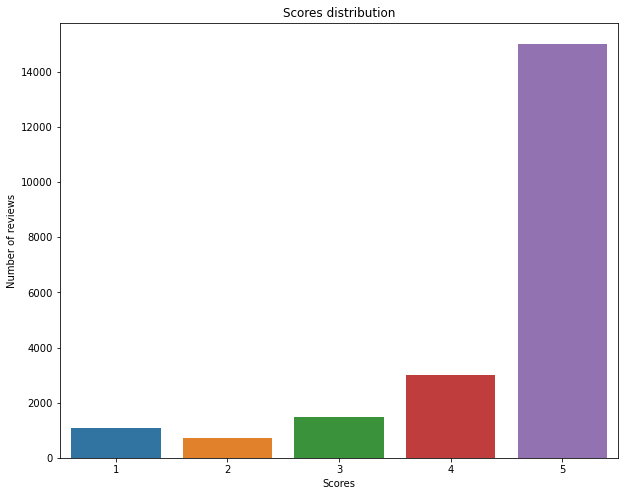

In [187]:
fig = plt.figure(figsize=(10, 8))
sns.countplot(x='scores', data=train_clean);
plt.title("Scores distribution");
plt.xlabel("Scores");
plt.ylabel("Number of reviews");


In [188]:
train_clean["scores"].value_counts()

5    15020
4     3016
3     1489
1     1066
2      719
Name: scores, dtype: int64

We see that the overwhelming majority of reviews (15020 from 21310) have score "5".

There are not so many negative reviews (with score "1" - 1066, with score "2" - 719, with score "3" - 1489).

Reviews with the score "4" are borderline. We prefer to avoid them.

Let choose as negative the reviews with the scores "1", "2" and "3". There are in total 3274 such reviews.

In [189]:
reviews_neg = pd.concat([train_clean[(train_clean['scores'] == 1) | (train_clean['scores'] == 2) | (train_clean['scores'] == 3)]])
reviews_neg

,scores,reviews,length,label
7,3,"Тяжелый, причем очень",23,0
9,3,Дизайн. Корпус,16,0
21,3,- Сканер отпечатка пальцев - Распознавание ли...,111,0
50,1,"Быстро разряжается,сильно глючит. Камера пери...",94,0
59,3,"Выглядит хлипко (но собран хорошо), является ...",477,0
...,...,...,...,...
21287,2,"Отсутствует запись телефонного разговора, нет...",88,0
21288,1,Телефон брал как обычную звонилку по работе.....,1234,0
21294,2,батарейка при использовании интернета тает на...,240,0
21297,2,Всё! Это полный отстой! Во первых: брак - не ...,452,0


Let choose approximately the same number of positive reviews (with the score "5") with the length as large as possible (to get more detailed descriptions). In this way we'll get the balanced data.

In [190]:
reviews_pos = train_clean[(train_clean["length"] > 177) & (train_clean["scores"] == 5)]
reviews_pos

,scores,reviews,length,label
12,5,"Отличный мощный аппарат, к преимуществам отне...",391,1
29,5,"Телефон отличный,на Беру цена просто сказочна...",201,1
53,5,1. Отличный экран. Фронтальная камера настоль...,430,1
55,5,"Дизайн Экран Звук (достаточно громкий, но дин...",181,1
56,5,"1. Камера достойная (сравнивая с 11 айфоном, ...",296,1
...,...,...,...,...
21283,5,"На борту андроид, можно поставить некоторые п...",743,1
21285,5,"Брал за 1990 в МТС. Дешевле модема, без привя...",178,1
21286,5,"+ Полноценная адресная книга, ограниченная то...",764,1
21290,5,Искал кнопочный телефон для пожилого человека...,207,1


Concat and shuffle the chosen reviews. Finally, we get 6546 reviews which we'll use for our sentiment prediction model.

In [191]:
data = shuffle(pd.concat([reviews_neg, reviews_pos]))

In [192]:
data

,scores,reviews,length,label
6579,3,Смартфон включается еще и от тряски. Нескольк...,166,0
15659,5,Уверенный прием. Достаточное количество опера...,253,1
5760,5,Оптимальный размер. Большой экран и не лопата...,207,1
392,1,Телефон сконструирован без датчика приближения...,195,0
7117,5,"Меня устраивает . Покупал потому что , старый ...",185,1
...,...,...,...,...
16675,5,- Огромная батарея. Держит заряд два дня. - В...,334,1
7219,5,"3 года пользовался 7 Plus, решил перейти на 1...",1127,1
3001,3,"Плохо держит заряд, садится на глазах, и это ...",151,0
16430,5,"В целом, неплохая модель, вот на свои деньги! ...",246,1


In [193]:
X = data['reviews'].values
y = data['label'].values

Now extract the test data.

In [194]:
with codecs.open('test.csv', 'r') as f:
    test_text = f.read()
    soup = BeautifulSoup(test_text, 'html.parser')
    test_reviews = soup.findAll('review')
    test_list = [test_review.text for test_review in test_reviews]

In [195]:
test = pd.DataFrame(test_list, columns=['text'])
test

,text
0,"Ужасно слабый аккумулятор, это основной минус ..."
1,ценанадежность-неубиваемостьдолго держит батар...
2,"подробнее в комментариях\nК сожалению, факт по..."
3,я любительница громкой музыки. Тише телефона у...
4,"Дата выпуска - 2011 г, емкость - 1430 mAh, тех..."
...,...
95,"Нет передней камеры, внутренняя память очень м..."
96,"Звук при прослушивание музыки хороший,не глючи..."
97,Очень маленькая память забита вшитыми и соверш...
98,"Удобный корпус,стандартное меню нокиа,камера д..."


In [196]:
X_test = test['text'].values

At the end of this part I would like to mention that during the work on setting the problem different approaches were considered: different data handling within clean_review function, different approaches for getting label-column, different combinations of finally chosen reviews, also, was made an attempt to apply stemming.

Here you can see the data preparation algorithm which showed the best result. 

## 2. Sentiment prediction model

In this section the sentiment prediction algorithm is presented.

Here we use pipeline consisting of CountVectorizer(), TfidfTransformer(), LinearSVC().

The accuracy score by cross-validation on the train data gave the result: 0.943.

The grid search on parameters improved the result to 0.9496.

The presented pipeline gave the result 0.95555 on the test data.

I would like to mention again that different models were tested, but the presented model gave the best result. 

In [197]:
stop_words = stopwords.words('russian')

In [198]:
def make_pipeline(vectorizer, transformer, classifier):
    return Pipeline([
            ('vectorizer', vectorizer),
            ('transformer', transformer),
            ('classifier', classifier)
        ])

In [199]:
def make_estimator(classifier, params_grid, scorer, data, labels):
    pipeline = make_pipeline(CountVectorizer(), TfidfTransformer(), classifier)
    grid_cv = RandomizedSearchCV(pipeline, params_grid, scoring=scorer, cv=5, n_iter=100, verbose=1, n_jobs=-1)
    grid_cv.fit(data, labels)
    return grid_cv

In [200]:
score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), LinearSVC()), X, y, cv=5).mean()
print("LinearSVC score:", score)

LinearSVC score: 0.9469824293353705


In [201]:
params_grid_vectorizer = {
    'vectorizer__max_df': [0.85, 0.9, 0.95, 1.0],
    'vectorizer__min_df': [1, 10, 20],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)],
    'vectorizer__stop_words': [stop_words, None]
}
params_grid_transformer = {
    'transformer__norm': ['l1', 'l2'],
    'transformer__smooth_idf': [True, False],
    'transformer__use_idf': [True, False],
    'transformer__sublinear_tf': [True, False]
}
params_grid_lsvc = {
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__max_iter': np.arange(200, 1000, 200),
    'classifier__tol': [1e-5, 1e-4, 1e-3],
    'classifier__C': [0.9, 1.0, 1.1, 1.2]
}

In [202]:
%%time
grid_search_lsvc = make_estimator(LinearSVC(), {**params_grid_vectorizer, **params_grid_transformer, **params_grid_lsvc}, 'accuracy', X, y)
print("LinearSVC:")
print("The best quality: ", grid_search_lsvc.best_score_)
print("Best parameters: ", grid_search_lsvc.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.5min finished


LinearSVC:
The best quality:  0.9515660809778457
Best parameters:  {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.95, 'transformer__use_idf': False, 'transformer__sublinear_tf': True, 'transformer__smooth_idf': False, 'transformer__norm': 'l2', 'classifier__tol': 1e-05, 'classifier__max_iter': 200, 'classifier__loss': 'hinge', 'classifier__C': 1.2}
CPU times: user 7.81 s, sys: 3.51 s, total: 11.3 s
Wall time: 6min 32s


In [203]:
make_pipeline(CountVectorizer(), TfidfTransformer(), LinearSVC()).fit(X, y).predict(X_test)

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0])

In [204]:
svc = grid_search_lsvc.best_estimator_
svc.steps

[('vectorizer', CountVectorizer(max_df=0.95, min_df=10, ngram_range=(1, 2))),
 ('transformer',
  TfidfTransformer(smooth_idf=False, sublinear_tf=True, use_idf=False)),
 ('classifier', LinearSVC(C=1.2, loss='hinge', max_iter=200, tol=1e-05))]

In [176]:
pred = svc.predict(X_test)
pred

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0])

In [177]:
with open('submission1.csv', 'w') as f:
    f.write(pd.DataFrame(pd.Series(map(str, range(0, 100))).str \
                         .cat(map(str, pd.Series(pred).apply(lambda x: 'neg' if x == 0 else 'pos')), sep=','), 
                         columns=['Id,y']).to_csv(sep=' ', index=False))

Below you can see the leaderboard screenshot with the final result.

![alt text](Leaderboard.png "Leaderboard")

Save the classification model in the file "sent_class.pkl".

In [207]:
with open('sent_class.pkl', 'wb') as f:
    pickle.dump(svc, f)

Check that everything was saved correct.

In [208]:
clf = joblib.load("sent_class.pkl")

In [215]:
print("Review: ", X[0])
print("Actual tonality: ", y[0])
print("Predicted tonality: ", clf.predict([X[0]]))

Review:   Смартфон включается еще и от тряски. Несколько раз замечал это в кармане. Обман Samsung о ёмкости батареи. Камеры хорошие, но не тянут на заявленные характеристики. 
Actual tonality:  0
Predicted tonality:  [0]


In [213]:
print("Review: ", X[1])
print("Actual tonality: ", y[1])
print("Predicted tonality: ", clf.predict([X[1]]))

Review:   Уверенный прием. Достаточное количество оперативной памяти, большой экран, чехол и наклеенная пленка в комплекте. Установленные программы вполне устраивают. Ну и конечно же батарея (использовал в режиме "новая игрушка" с 95% разрядился до 45% за день) 
Actual tonality:  1
Predicted tonality:  [1]


In [214]:
print("Review: ", X[100])
print("Actual tonality: ", y[100])
print("Predicted tonality: ", clf.predict([X[100]]))

Review:   - быстрый - работает без сбоев - шикарная камера с 4 объективами - четкие снимки - гибкие настройки съемки видео - красивый дизайн - большой экран - удобное расположение кнопки включения и сенсора отпечатка пальца - сразу две симки + флешка - ИК-порт с программой для управления TV любых производителей - батареи хватает примерно на 2 дня - достаточно громкий динамик - настройки звука под разные типы наушников - в комплекте идет бампер, защитная пленка уже наклеена на экран - зарядка полностью заряжает тлф за 30 мин 
Actual tonality:  1
Predicted tonality:  [1]
